# scikit-learn을 이용한 결정 트리

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

import graphviz
from sklearn.tree import export_graphviz
from imageio import imread

cm2 = ListedColormap(['C1', 'C2'])
cm3 = ListedColormap(['C1', 'C2', 'C3'])

## 개요

- 아래 그림처럼 특성의 임계값을 기준으로 학습세트의 샘플들을 좌우로 분리하여 나무형태로 만드는 방법


<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_dtc_002.png"/>

- 모든 분리가 끝나면 리프 노드leaf node라 불리는 가장 아래쪽 노드의 샘플들을 보고 예측

- 그림에 첫 분기 왼쪽 주황색 노드에 모인 샘플들은 1번 클래스가 50개, 나머지 클래스 샘플은 없으므로 데이터의 두번째 특성 `X[2]<=2.45`면 무조건 첫번째 클래스로 판별

- 결정해야 하는 것
    - 어떤 특성으로 분기할지? `X[1]`, `X[2]`, ..., `X[n]`?
    - 특성이 정해지면 어떤 값으로 분기할지?


- 회귀문제인 경우 아래 그림처럼 출력값을 노드에 모인 샘플 타겟의 평균으로 예측하여 해결

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_tree_regression_001.png"/>

## 분류

### 데이터 생성

In [2]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)

### 데이터 확인

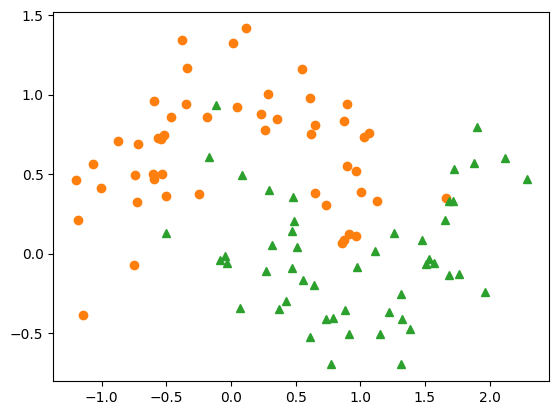

In [3]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax.plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')

plt.show()

### 학습

In [4]:
# 모델 로딩[+]
from sklearn.tree import DecisionTreeClassifier

In [5]:
# 모델 생성과 fit[+]
tree = DecisionTreeClassifier(max_depth=1, random_state=0).fit(X, y)

<ipython-input-6-a577f6e673f9>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tree_img = imread(graph.render())


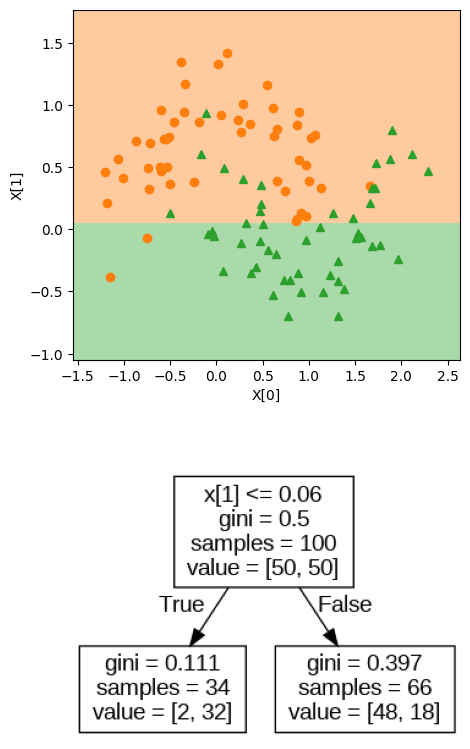

In [6]:
# 그림으로 확인
eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 100)
yy = np.linspace(y_min, y_max, 100)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

Z = tree.predict(X_grid)
Z = Z.reshape(X1.shape)

fig, ax = plt.subplots(figsize=(5,10), nrows=2, ncols=1, dpi=100)

ax[0].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[0].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[0].contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)

ax[0].set_xlabel('X[0]')
ax[0].set_ylabel('X[1]')

###############################################
# 트리 그림 그리기[+]
dot_data = export_graphviz(tree, out_file=None,
                max_depth=9, impurity=True)
graph = graphviz.Source(dot_data, format="png")
tree_img = imread(graph.render())
ax[1].imshow(tree_img)
ax[1].axis('off')
###############################################
plt.show()


- value = [32, 2] -> 34개 중에서 32개가 맞는 정답
  - 불순도가 낮다

In [ ]:
    """
    k: 특성의 인덱스 -> x[1]의 1
    tk: k번째 특성을 나눌 임계값 0.06
    X, y: left, right로 나눌 데이터와 타겟값
    """

### 지니 불순도Gini impurity

- $i$번째 노드에서 계산되는 지니불순도Gini impurity

$$
G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2
$$

- 위 식에서 $p_{i,k}$는 $i$번째 노드에 있는 샘플 중 클래스 $k$에 속한 샘플의 비율

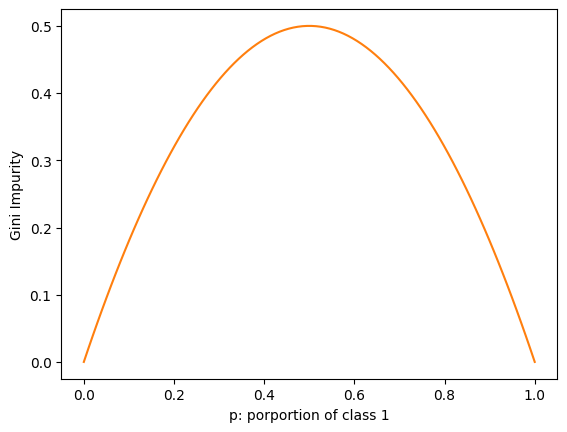

In [7]:
# 지니 불순도 그래프 확인[+]

fig = plt.figure()
ax = plt.axes()

p = np.linspace(0,1,100)
G = 1 - (p**2 + (1-p)**2)

ax.plot(p, G, color='C1')
ax.set_xlabel("p: porportion of class 1")
ax.set_ylabel("Gini Impurity")

plt.show()

클래스의 확률이 1 or 0일때는 지니 불순도가 낮다.  
클래스의 확률이 0.5일때 지니 불순도가 가장 높다.

In [8]:
# np.unique()함수 실험
np.unique(np.array([1,1,2,3,3,4]), return_counts=True)

# 각 숫자의 unique    , 각 숫자의 출현횟수
# (array([1, 2, 3, 4]), array([2, 1, 2, 1]))


(array([1, 2, 3, 4]), array([2, 1, 2, 1]))

In [10]:
# 지니불순도 기준 작성 [+]
def gini(k, tk, X, y):
    """
    k: 특성의 인덱스
    tk: k번째 특성을 나눌 임계값
    X, y: left, right로 나눌 데이터와 타겟값
    """
    # split X w.r.t tk
    cond = X[:,k] <= tk # True or False
    X_left, y_left = X[cond], y[cond]
    X_right, y_right = X[~cond], y[~cond]

    # calc. gini impurity left node, right node
    G_left = 1- np.sum(
            (np.unique(y_left, return_counts=True)[1] / y_left.shape[0])**2
        )
    G_right = 1- np.sum(
            (np.unique(y_right, return_counts=True)[1] / y_right.shape[0])**2
        )

    return (G_left, G_right)

In [12]:
# 위 그림처럼 되는지 확인[+]
# 첫번째 값을 0.06 임계값을 기준으로 지니값 구하기
G_left, G_right = gini(1, 0.06, X, y)

print(f"Left node gini={G_left:.3f}, Right node gini={G_right:.3f}")

Left node gini=0.111, Right node gini=0.397


### 목적함수

- 지니 불순도를 기준으로 다음 함수의 값이 가장 작아지는 위치에서 분기

$$
J(k, t_k) = \frac{m_{\text{left}}}{m} G_{\text{left}} + \frac{m_{\text{right}}}{m} G_{\text{right}}
$$

- $k$는 특성번호(0 or 1), $t_k$는 특성 $k$의 분기값, $m$은 샘플 개수

In [13]:
# 목적함수 작성 [+]
def J(k, tk, criterion, X, y):
    # split X w.r.t tk
    num_left = np.sum(X[:,k] <= tk)
    num_right = X.shape[0] - num_left

    G_left, G_right = criterion(k, tk, X, y)

    return (num_left/X.shape[0])*G_left + (num_right/X.shape[0])*G_right

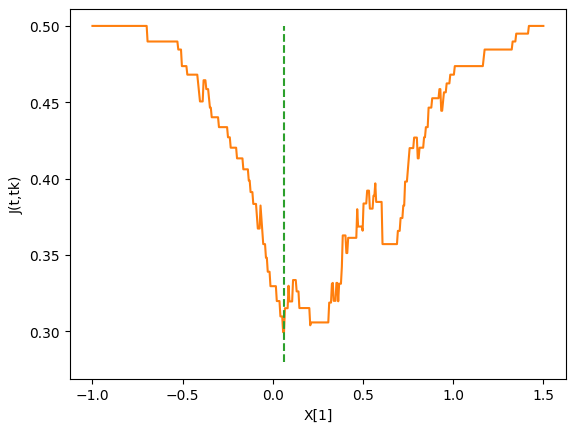

In [14]:
# 목적함수 그리기[+]

############################################
# 분기점을 임의로 만들고
T = np.linspace(-1, 1.5, 500) # -1 ~ 1.5까지 500등분

############################################
# 목적함수값을 저장할 리스트
crit = []

############################################
# T에 대해서 모두 목적함수값을 찍어본다.
for t in T:
    crit.append(J(1, t, gini, X, y))

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(T, crit, color='C1')
ax.vlines(0.06, 0.28, 0.5, linestyles='--', color='C2')

ax.set_xlabel('X[1]')
ax.set_ylabel('J(t,tk)')

plt.show()

0.06에서 목적함수가 최소

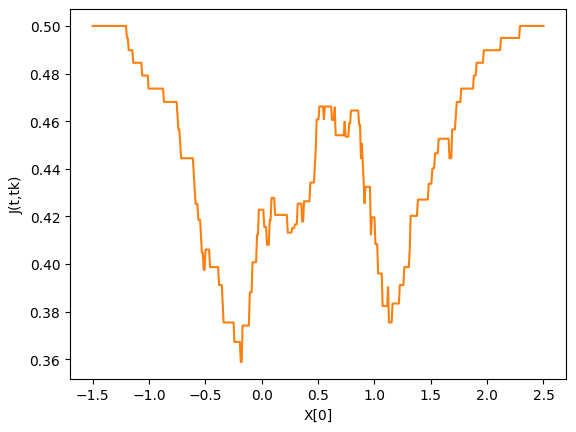

In [15]:
# X[0]에 대해서 J 그리기[*]
T = np.linspace(-1.5, 2.5, 500)
crit = []

for t in T:
    crit.append(J(0, t, gini, X, y))

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(T, crit, color='C1')

ax.set_xlabel('X[0]')
ax.set_ylabel('J(t,tk)')

plt.show()

<ipython-input-16-78a7bc78a6fb>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tree_img = imread(graph.render())


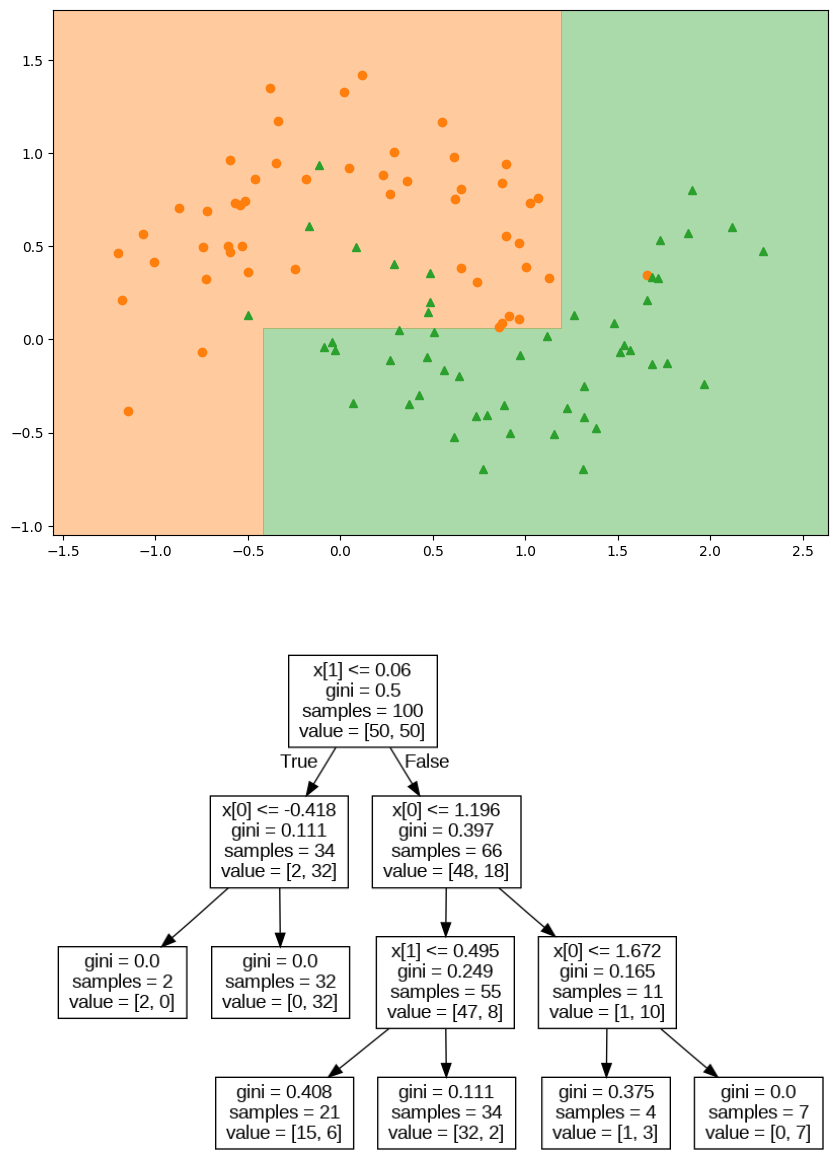

In [16]:
##################################################
# 깊이 3으로 fit[+]
tree = DecisionTreeClassifier(max_depth=3, random_state=0).fit(X, y)
##################################################


# 그림으로 확인
eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 1000)
yy = np.linspace(y_min, y_max, 1000)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

Z = tree.predict(X_grid)
Z = Z.reshape(X1.shape)

fig, ax = plt.subplots(figsize=(10,15), nrows=2, ncols=1, dpi=100)

ax[0].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[0].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[0].contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)

# 트리 그림 그리기[+]
dot_data = export_graphviz(tree, out_file=None,
                max_depth=9, impurity=True)
graph = graphviz.Source(dot_data, format="png")
tree_img = imread(graph.render())
ax[1].imshow(tree_img)
ax[1].axis('off')

plt.show()


<ipython-input-19-49d593f65ba9>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tree_img = imread(graph.render())


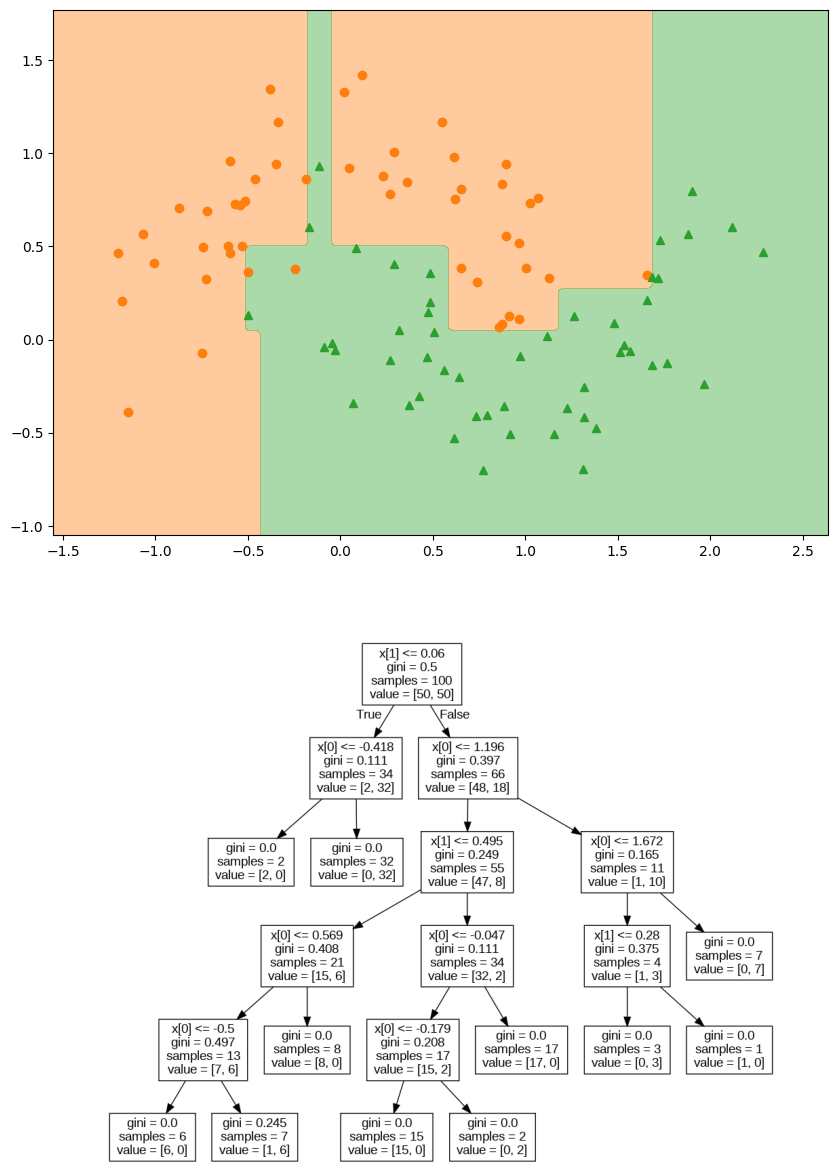

In [19]:
##################################################
# 깊이 5로 fit[+]
tree = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X, y)
##################################################

# 그림으로 확인
eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 100)
yy = np.linspace(y_min, y_max, 100)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

Z = tree.predict(X_grid)
Z = Z.reshape(X1.shape)

fig, ax = plt.subplots(figsize=(10,15), nrows=2, ncols=1, dpi=100)

ax[0].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[0].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[0].contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)

# 트리 그림 그리기[+]
dot_data = export_graphviz(tree, out_file=None,
                max_depth=9, impurity=True)
graph = graphviz.Source(dot_data, format="png")
tree_img = imread(graph.render())
ax[1].imshow(tree_img)
ax[1].axis('off')

plt.show()


- 트리모델의 경우 스케일링 할 필요x

### 규제

- 과대적합을 막기 위한 인자
    - `max_depth`: 최대 깊이
    - `max_leaf_nodes`: 최대 잎노드
    - `min_samples_leaf`: 잎노드에 포함될 최소 샘플 개수

<ipython-input-20-51b44e35b422>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tree_img = imread(graph.render())


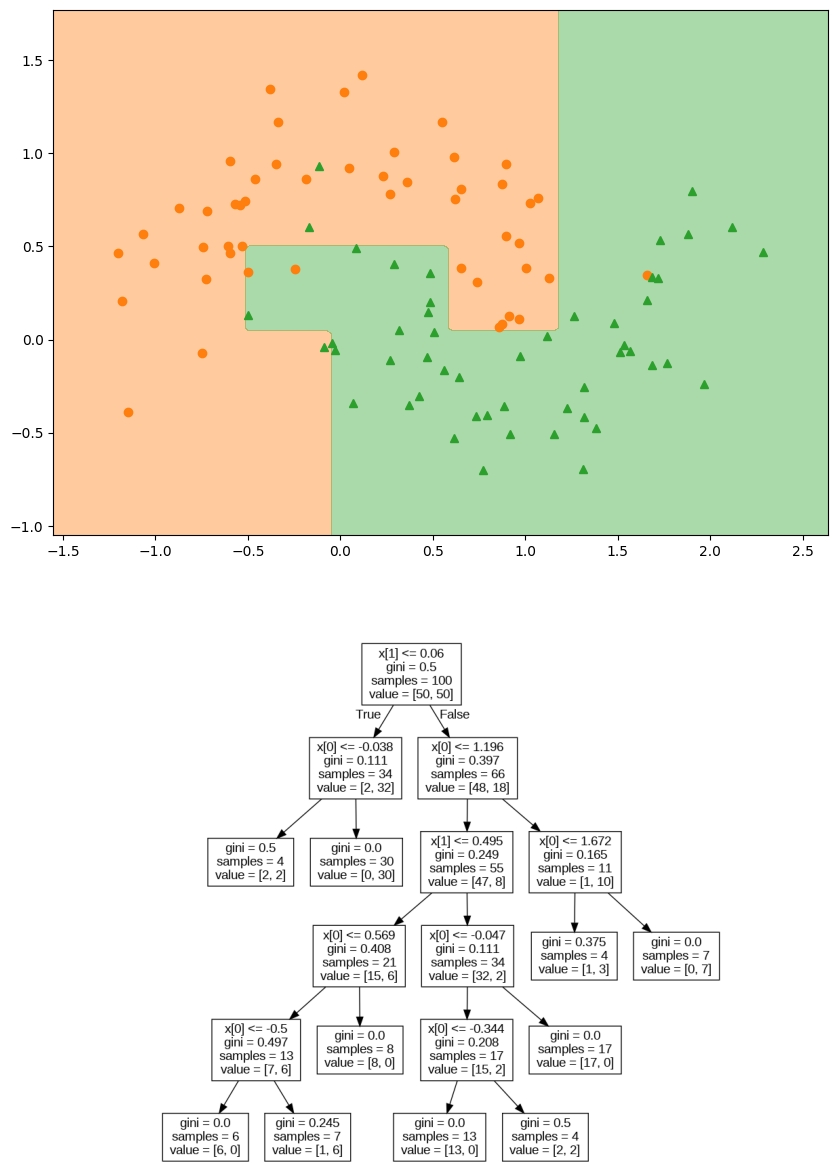

In [20]:
#########################################
# min_sample_leaf를 사용하여 규제[+]
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, random_state=0).fit(X, y)
#########################################

# 그림으로 확인
eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 100)
yy = np.linspace(y_min, y_max, 100)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

Z = tree.predict(X_grid)
Z = Z.reshape(X1.shape)

fig, ax = plt.subplots(figsize=(10,15), nrows=2, ncols=1, dpi=100)

ax[0].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[0].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[0].contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)

# 트리 그림 그리기[+]
dot_data = export_graphviz(tree, out_file=None,
                max_depth=9, impurity=True)
graph = graphviz.Source(dot_data, format="png")
tree_img = imread(graph.render())
ax[1].imshow(tree_img)
ax[1].axis('off')

plt.show()

## 회귀

### 데이터 생성

In [21]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

### 데이터 확인

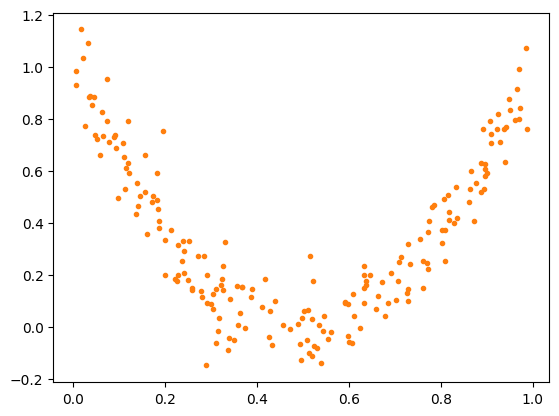

In [22]:
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X, y , '.', color='C1')

plt.show()

### 학습

In [23]:
# 모델 로딩[+]
from sklearn.tree import DecisionTreeRegressor

In [24]:
# 모델 생성과 fit[+]
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=1)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=1, random_state=42)

In [25]:
# 분기점 확인[+]
tree_reg.tree_.threshold

# array([ 0.19734927, -2.        , -2.        ])
#         분기점

array([ 0.19734927, -2.        , -2.        ])

<ipython-input-26-5d5af97d5258>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tree_img = imread(graph.render())


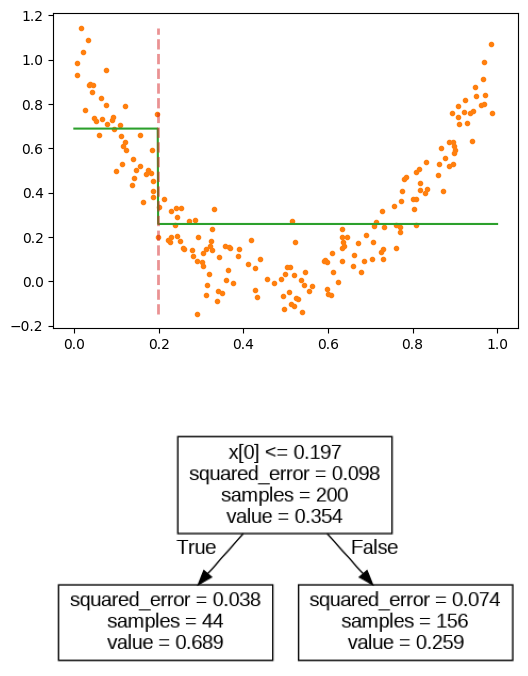

In [26]:
x = np.linspace(0, 1, 1000)
y_pred = tree_reg.predict(x.reshape(-1,1))

fig, ax = plt.subplots(figsize=(6,9), nrows=2, ncols=1, dpi=100)

ax[0].plot(X, y , '.', color='C1')
ax[0].plot(x, y_pred, color='C2')

##########################################################
# 결정경계 그리기[+]
for thr in tree_reg.tree_.threshold:
    if X.min() < thr < X.max():
        ax[0].vlines(thr, ymin=y.min(), ymax=y.max(),
                     ls='--', color='C3', lw=2, alpha=0.5)
##########################################################


# 트리 그림 그리기
dot_data = export_graphviz(tree_reg, out_file=None,
                max_depth=9, impurity=True)
graph = graphviz.Source(dot_data, format="png")
tree_img = imread(graph.render())
ax[1].imshow(tree_img)
ax[1].axis('off')

plt.show()

### 평균제곱오차Mean Squared Error

- 특정 node의 MSE

$$
\text{MSE}_{\text{node}} = \frac{1}{m_{\text{node}}} \sum_{i \in \text{node}} \left( \bar{y}_{\text{node}} - y^{(i)} \right)^2
$$

- $\bar{y}_{\text{node}}$는 해당 노드의 평균 타겟값, $y^{(i)}$는 해당 노드에 있는 $i$번째 샘플의 타겟값, $m_{\text{node}}$는 노드의 샘플 수

- $\bar{y}_{\text{node}}$는 다음 식으로 계산

$$
\bar{y}_{\text{node}} = \frac{1}{m_{\text{node}}} \sum_{i \in \text{node}} y^{(i)}
$$



In [27]:
# mse 기준 작성 [+]
def mse(k, tk, X, y):
    """
    k: 특성의 인덱스
    tk: k번째 특성을 나눌 임계값
    X, y: left, right로 나눌 데이터와 타겟값
    """
    # split X w.r.t tk
    cond = X[:,k] <= tk
    X_left, y_left = X[cond], y[cond]
    X_right, y_right = X[~cond], y[~cond]

    mse_left = np.mean((y_left - y_left.mean())**2)
    mse_right = np.mean((y_right - y_right.mean())**2)

    return mse_left, mse_right



In [28]:
# 위 그림처럼 되는지 확인[+]
MSE_left, MSE_right = mse(0, 0.197, X, y)

print(f"Left node squared error={MSE_left:.3f}")
print(f"Right node squared error={MSE_right:.3f}")

Left node squared error=0.038
Right node squared error=0.074


### Value

- 특정 node의 value

$$
\text{value}_{\text{node}} = \frac{1}{m_{\text{node}}} \sum_{i \in \text{node}}  y^{(i)}
$$

- 그 node에 있는 샘플의 타겟값 평균

In [29]:
# 위 그림 노드의 value 확인[+]
print(f"Root node value={y.mean():.3f}")
print(f"Left node value={y[X[:,0]<=0.197].mean():.3f}")
print(f"Right node value={y[X[:,0]>0.197].mean():.3f}")

Root node value=0.354
Left node value=0.689
Right node value=0.259


### 목적함수

- 평균제곱오차를 기준으로 다음 함수의 값이 가장 작아지는 위치에서 분기

$$
J(k, t_k) = \frac{m_{\text{left}}}{m} MSE_{\text{left}} + \frac{m_{\text{right}}}{m} MSE_{\text{right}}
$$

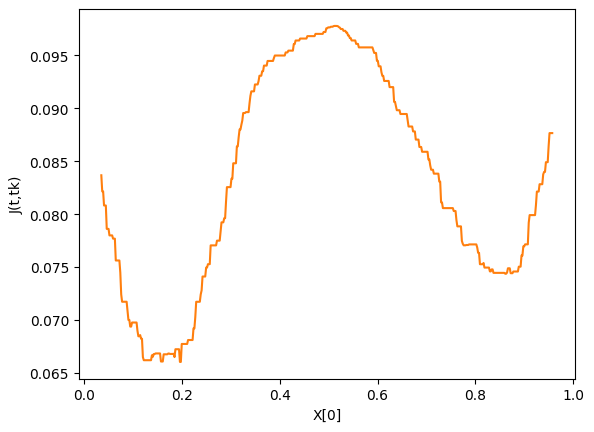

In [30]:
# 목적함수 그리기[+]

eps = 0.03
############################################
# 분기점을 임의로 만들고
T = np.linspace(X.min()+eps, X.max()-eps, 500)

############################################
# 목적함수값을 저장할 리스트
crit = []

############################################
# T에 대해서 모두 목적함수값을 찍어본다.
for t in T:
    crit.append(J(0, t, mse, X, y))

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(T, crit, color='C1')

ax.set_xlabel('X[0]')
ax.set_ylabel('J(t,tk)')

plt.show()

In [31]:
##################################################
# 깊이 3으로 fit[+]
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg.fit(X, y)

##################################################

DecisionTreeRegressor(max_depth=3, random_state=42)

<ipython-input-32-bdd0eee37016>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tree_img = imread(graph.render())


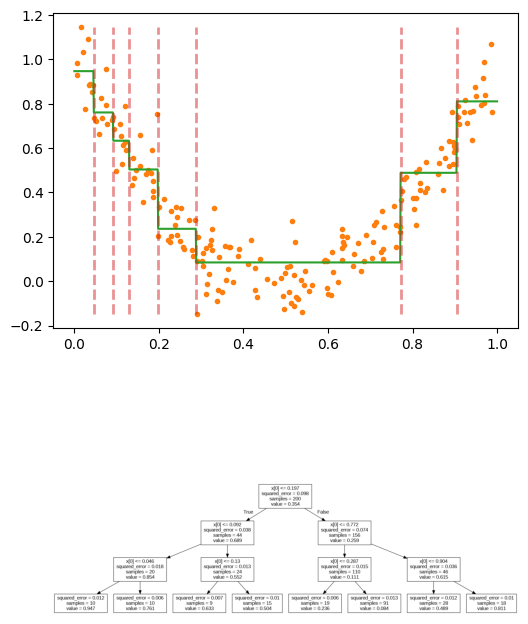

In [32]:
# 그림 확인
x = np.linspace(0, 1, 1000)
y_pred = tree_reg.predict(x.reshape(-1,1))

fig, ax = plt.subplots(figsize=(6,9), nrows=2, ncols=1, dpi=100)

ax[0].plot(X, y , '.', color='C1')
ax[0].plot(x, y_pred, color='C2')

for thr in tree_reg.tree_.threshold:
    if X.min() < thr < X.max():
        ax[0].vlines(thr, ymin=y.min(), ymax=y.max(),
                     ls='--', color='C3', lw=2, alpha=0.5)

# 트리 그림 그리기
dot_data = export_graphviz(tree_reg, out_file=None,
                max_depth=9, impurity=True)
graph = graphviz.Source(dot_data, format="png")
tree_img = imread(graph.render())
ax[1].imshow(tree_img)
ax[1].axis('off')

plt.show()

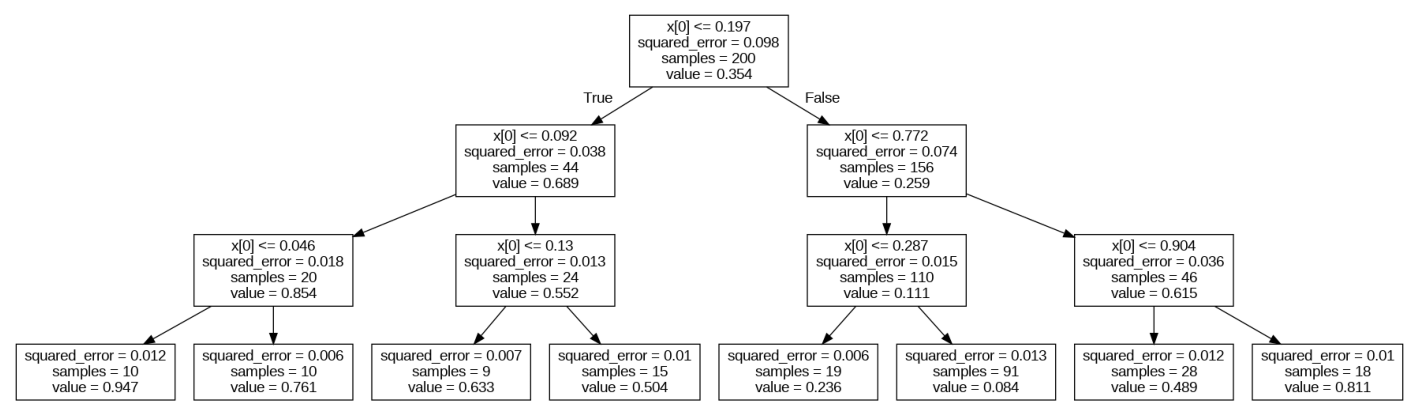

In [33]:
# 그림 크기 보기
fig = plt.figure(figsize=(15,10), dpi=120)
ax = plt.axes()
ax.imshow(tree_img)
ax.axis('off')
plt.show()

### 규제

- 과대적합을 막기 위한 인자 `max_depth`, `max_leaf_nodes`, `min_samples_leaf`

In [34]:
# tree_reg2에 규제를 걸어 결과를 일반화 하기, max_leaf_nodes[+]
tree_reg1 = DecisionTreeRegressor(random_state=42) # 규제없는 모델
tree_reg2 = DecisionTreeRegressor(random_state=42, max_leaf_nodes=10) # 규제있는 모델

In [35]:
# fit[+]
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=10, random_state=42)

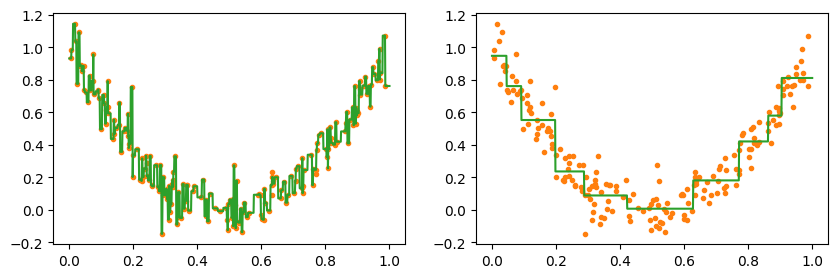

In [36]:
# 그림으로 확인

x = np.linspace(0, 1, 1000)
y_pred1 = tree_reg1.predict(x.reshape(-1,1))
y_pred2 = tree_reg2.predict(x.reshape(-1,1))

fig, ax = plt.subplots(figsize=(10,3), nrows=1, ncols=2, dpi=100)

ax[0].plot(X, y , '.', color='C1')
ax[0].plot(x, y_pred1, color='C2')

ax[1].plot(X, y , '.', color='C1')
ax[1].plot(x, y_pred2, color='C2')


plt.show()

## 실습과제: 실제 데이터에 적용[*]

### 분류: 유방암 데이터

- 이번 실습에서는 특징이 많은 실제 데이터에 결정 트리를 적합시켜봅니다.

- 아래 로드된 유방암 데이터를 결정 트리로 모델링하는 과정에서 적절한 규제를 적용하여 성능을 튜닝하세요.

- 그리고 특징을 스케일링하는 것이 트리 모델에서 어떤 의미가 있는지도 생각해보겠습니다.

In [37]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42
)

- 규제가 없는 모델을 만들고 피팅한 후 학습과 테스트 세트에 점수를 확인하세요.

In [38]:
tree =  DecisionTreeClassifier(random_state=0).fit(X_train, y_train) # 규제 없는 모델

print(f"학습 세트 정확도: {tree.score(X_train, y_train):.3f}")
print(f"테스트 세트 정확도: {tree.score(X_test, y_test):.3f}")

학습 세트 정확도: 1.000
테스트 세트 정확도: 0.937


- 적절히 규제를 하는 모델을 만들고 피팅한 후 학습과 테스트 세트에 점수를 확인하세요.

- 규제 옵션은 `max_depth`를 사용하세요.

- 규제전 보다 더 결과과 좋아지도록 `max_depth`를 설정하세요.

In [39]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train, y_train) # 규제 있는 모델

print(f"학습 세트 정확도: {tree.score(X_train, y_train):.3f}")
print(f"테스트 세트 정확도: {tree.score(X_test, y_test):.3f}")

학습 세트 정확도: 0.988
테스트 세트 정확도: 0.951


- 대부분 솔버가 있는 모델의 경우 스케일링은 좀 더 좋은 최적점으로 수렴하게 만들기 때문에 학습에 좋은 영향을 미칩니다.

- 트리 모델에 대해서 스케일링 효과를 확인해봅시다.

In [40]:
# MinMaxScalar로 스케일링하면 결과가?
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train)
X_train_scaled = minmax_scaler.transform(X_train)
X_test_scaled = minmax_scaler.transform(X_test)

tree = DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train_scaled, y_train)

print(f"학습 세트 정확도: {tree.score(X_train_scaled, y_train):.3f}")
print(f"테스트 세트 정확도: {tree.score(X_test_scaled, y_test):.3f}")

학습 세트 정확도: 0.988
테스트 세트 정확도: 0.951


스케일링을 해도 결과는 같다
- 즉 트리모델은 스케일링 필요가 없다

- 테스트 셋에 대한 `confusion_matrix`와 `classification_report`를 작성하세요.

In [41]:
# 모듈 임포트
from sklearn.metrics import confusion_matrix, classification_report

In [42]:
y_test_pred = tree.predict(X_test_scaled)

In [43]:
confusion_matrix(y_test, y_test_pred)

array([[49,  4],
       [ 3, 87]])

In [44]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        53
           1       0.96      0.97      0.96        90

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



## 장단점

- 장점
    - 빠른 속도
    - 모델을 시작화하여 비전문가도 결과 과정을 이해하기 쉬움
    - 데이터 정규화, 표준화 같은 전처리 필요없음
- 단점
    - 쉬운 과대적합
    - 학습데이터를 벗어나는 영역에서 예측 불가능